In [4]:
using PyPlot
using JuMP, Ipopt
using Random
using Distributions
using SpecialFunctions

include("../src/model.jl");
include("../src/diagnostics.jl");
include("../src/optimization.jl");
include("../src/plotting.jl");
include("../src/defaults.jl");
include("../src/ensemble.jl");
include("../src/stochastic_optimization.jl");
Random.seed!(2);


### Ensemble optimization

Problem for some reason becomes infeasible with several models...

In [5]:
function uncertain_ECS_ensemble(feedback_mean::Float64, feedback_var::Float64, Nsamples::Int64; plot_dist=false)
    d = Normal(feedback_mean, feedback_var)
    feedback_samples = rand(d, Nsamples)

    # Filter out samples with very large (unphysical) ECS
    feedback_samples = feedback_samples[(feedback_samples .> 0.) .& (feedback_samples .<= 0.9)]

    ECS₀ = 1.2
    ECS_mean = ECS₀/(1. .- feedback_mean)
    ECS_samples = ECS₀ ./ (1. .-feedback_samples);
    
    if plot_dist
        hist(ECS_samples, bins=0.:0.5:10., density=true)
        xlim([0,10])
        xlabel(L"Equilibrium Climate Sensitivity ($^{\circ}$C)")
        ylabel("Probability");
    end
    
    ensemble = Dict{String, ClimateModel}();

    for member_id in 1:length(ECS_samples)
        model = ClimateModel(ECS=ECS_samples[member_id]);
        ensemble[string(member_id)] = model
    end
    
    return ensemble
end

uncertain_ECS_ensemble (generic function with 1 method)

Filtered out 6 unphysical samples.LOCALLY_SOLVED

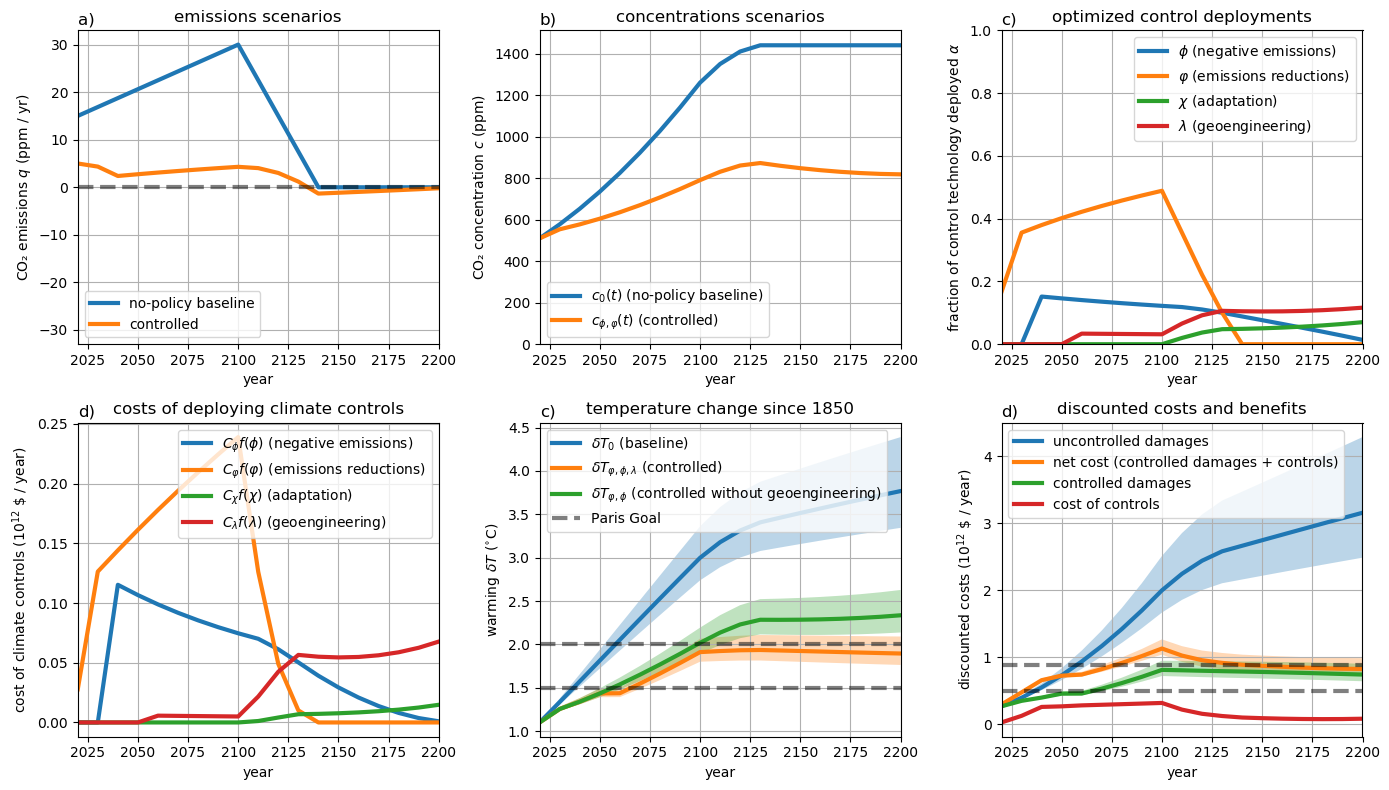

In [6]:
ensemble1 = uncertain_ECS_ensemble(0.65, 0.13, 200);
m = optimize_stochastic_controls!(ensemble1, temp_goal = 2.0);
plot_ensemble(ensemble1)

Filtered out 32 unphysical samples.LOCALLY_SOLVED

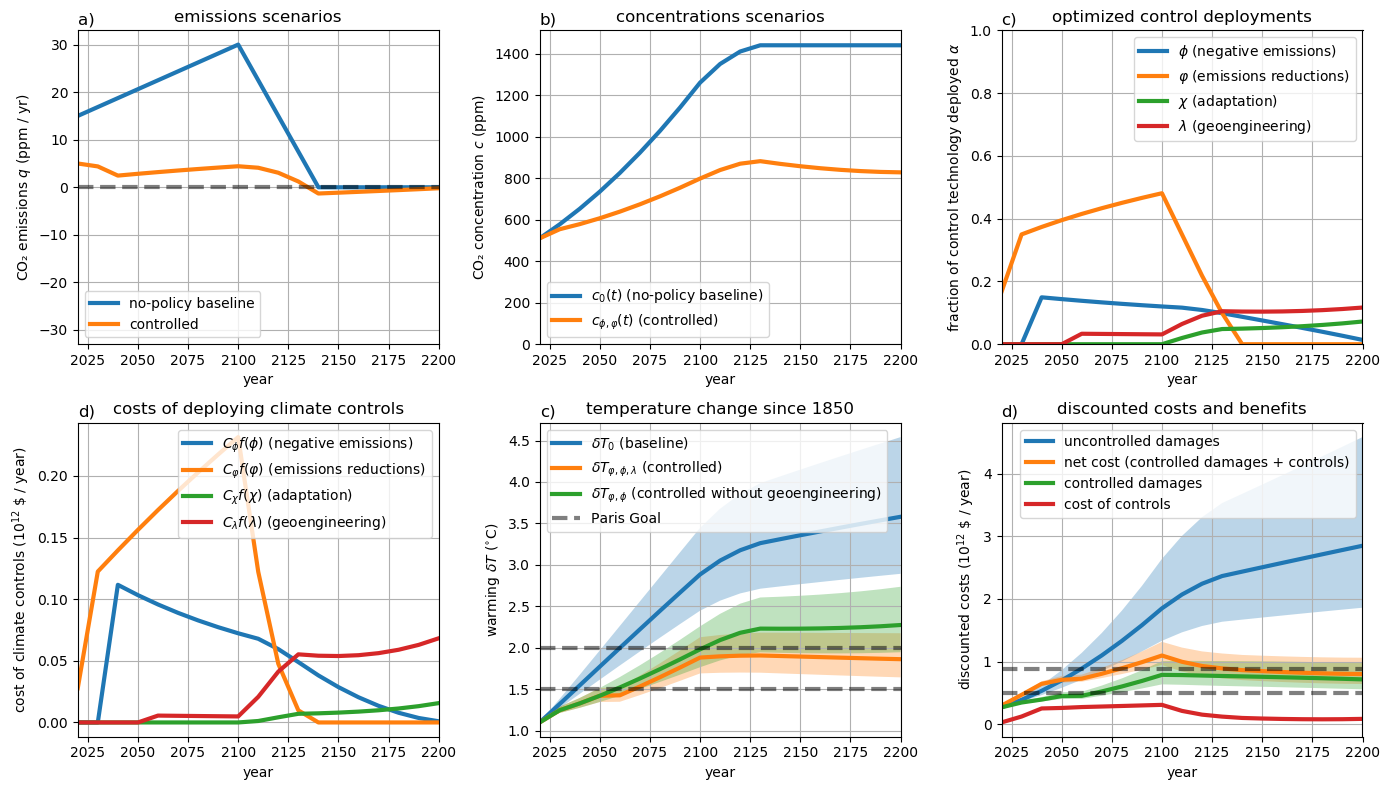

In [7]:
ensemble2 = uncertain_ECS_ensemble(0.65, 0.26, 200);
m = optimize_stochastic_controls!(ensemble2, temp_goal = 2.0);
plot_ensemble(ensemble2)